# Exercise: colour histograms

A colour histogram is a representation of the distribution of colours in an image. Given a discrete predefined colour space (e.g. red, green, blue), the colour histogram is obtained by counting the number of times each colour occurs in the image array. Histogram Intersection is a technique that can be used to match a pair of histograms.  

Given a pair of histograms, e.g. of an input image I and a model M, each containing n bins, the intersection of the histograms is defined to be
$∑_{i,j}min(I,M)$ where j ranges over each colour in the histograms. The result of the intersection of a model histogram with an image histogram is the number of pixels from the model that have corresponding pixels of the same colour in the image.

## Import and Load

In [1]:
#import modules and images
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO

#generate random image from lorenpicsom
#image credit: https://picsum.photos/
url = 'https://picsum.photos/300/200'
response = requests.get(url)
imgI = np.asarray(Image.open(BytesIO(response.content)))
imgM = np.asarray(Image.open(BytesIO(response.content)))

#or you can use image of mine.
imgI = Image.open('assets/test_image_boat.jpg')
imgM = Image.open('assets/test_image_island.jpg')

(h,w) = imgI.size
imgI = np.asarray(imgI.resize((h//3,w//3), Image.ANTIALIAS))
imgM = np.asarray(imgM.resize((h//3,w//3), Image.ANTIALIAS))

In [2]:
def plot(imgs, titles=[]):
    fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
    i=0
    for ax, theta in zip(axs, imgs):
        ax.imshow(np.clip(theta,0,255))       
        if titles: ax.title.set_text(titles[i])
        i=i+1              
    plt.show()

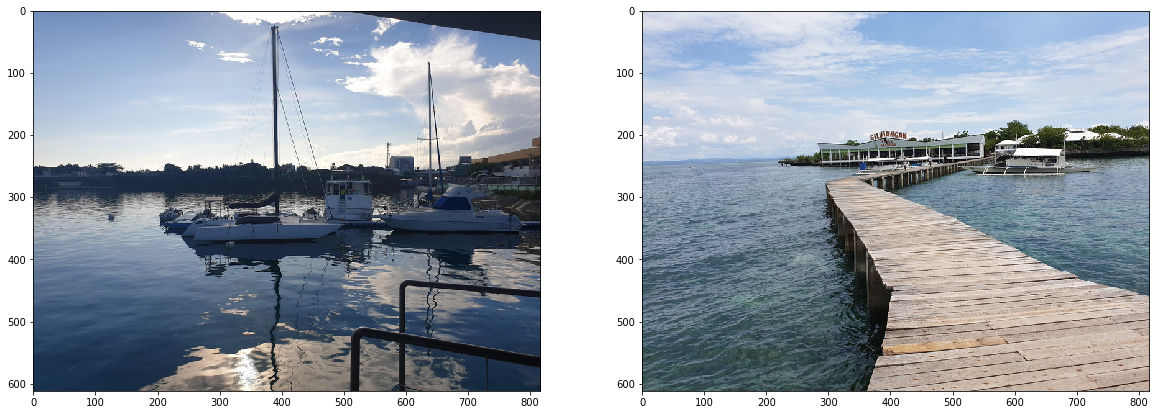

In [3]:
plot([imgI,imgM])

>a) Write a histogram function that returns the 3D colour histogram of an input image. Visualize the 3D histogram and save the figure(s). For a given video sequence, use the above function to construct and visualise the histograms of each frame.
Exercise: colour histograms

In [9]:
bins=16

In [78]:
def Histogram3d(img):
    # hist3d: output 3d histogram, shape=(bins,bins,bins) for (R,G,B)
    hist3d=np.zeros((bins,bins,bins),dtype=np.int)
    step = 256/bins
    
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            
            bin = list(map(int,img[y,x]//step))
            hist3d[bin] += 1
            
    return hist3d

In [61]:
import colorsys
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm

def plot3dhistRGB(img):
    [xs, ys] = img.shape[1], img.shape[0]
    pixels = {}
    r_, g_, b_, colours = [],[],[],[]
    
    step = 256/bins
    for x in range(0, xs):
      for y in range(0, ys):
        [r, g, b] = img[y, x]

        r_.append(r//step)
        g_.append(g//step)
        b_.append(b//step)
        colours.append([r/255, g/255, b/255])

    hist_bins= Histogram3d(img)
    hist_positive = hist_bins > 0.0
    color_densities = np.float32(hist_bins[hist_positive])

    density_max = np.max(color_densities)
    color_densities = 20*color_densities / density_max
    
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(r_, g_, b_, s=color_densities,c=colours, lw=0)
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    fig.add_axes(ax)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(imgM)

    plt.show()   

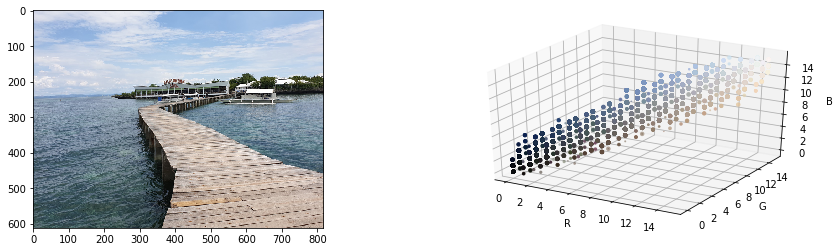

In [62]:
plot3dhistRGB(imgI)

In [ ]:
plot3dhistRGB(imgM)

>b) Write a function that returns the intersection of a pair of histograms. For a given video sequence, use the histogram intersection function to calculate the intersection between the consecutive frames, e.g., between It and It+1, between It+1 and It+2 etc. Visualise and present the intersection values. Find a way to normalize the intersection. Does that cause any changes in the results?

I am going to establish the strategy to get the intesection of histogram between the consecutive frames.
1. split each frames into volume of numpy image arrays for given video sequence.  
~~~
input: video sequence  
output: np.ndarray[h,w,c,frames]
~~~

   
2. calculate the 3d histogram of each frames.
~~~
input: np.ndarray[h,w,c,frames]
output: np.ndarray[hist,c,frames]
~~~

   
3. calculate the intersection of a pair of histograms using simple matrix subtraction.
~~~ 
input: np.ndarray[hist,c,frames]
output: np.ndarray[hist,c,frames-1]
~~~

~~~
intersection of histogram = np.minimum(np.ndarray[hist,c,frames-1], np.ndarray[hist,c,frames])
~~~


Before we get started, Let's define the functuin to load video file and convert into np.array

In [68]:
# !apt-get install --no-install-recommends ffmpeg && pip install ffmpeg scikit-video

import skvideo.io
import skvideo.datasets
import imageio
from IPython.display import Video

# convert video sequence into np.array
video = skvideo.io.vread(skvideo.datasets.bigbuckbunny())
print(video.shape)

#Display video
Video('assets/test_video.mp4', width=480, height=360) 
#the width and height option as additional thing new in Ipython 7.6.1

(132, 720, 1280, 3)


In [81]:
bins=16

def video_hist_intersection(video):    
    
    frames, height, weight, channels = video.shape
       
    video_3dhist = np.zeros((frames,bins,bins,bins),dtype=np.int)
    hist_intersections =np.zeros((frames,bins,bins,bins),dtype=np.int)
    
    for frame in range(frames):
        # calculate 3d histogram of each frames
        video_3dhist[frame] = np.asarray(Histogram3d(video[frame]))
        
        # calculate the intersection of a pair of histogram
        hist_intersections = np.minimum(video_3dhist[frame-1],video_3dhist[frame])
    
    return hist_intersections

In [ ]:
video_hist_intersection(video)

>c) What does the intersection value represent for a given input video? Can you use it to make a decision about where the scene in the video changes? How robust is the histogram intersection technique to changes? Where does it fail? What would be other application areas where histogram calculation and histogram intersection can be used?

### Deprecated Functions

In [ ]:
# plot in hsv
import colorsys

img = imgI
[xs, ys] = img.shape[1], img.shape[0]
max_intensity = 100
hues = {}

# (3) Examine each pixel in the image file
for x in range(0, xs):
  for y in range(0, ys):
    # (4)  Get the RGB color of the pixel
    [r, g, b] = img[y, x]

    # (5)  Normalize pixel color values
    r /= 255.0
    g /= 255.0
    b /= 255.0

    # (6)  Convert RGB color to HSV
    [h, s, v] = colorsys.rgb_to_hsv(r, g, b)

    # (7)  Marginalize s; count how many pixels have matching (h, v)
    if h not in hues:
      hues[h] = {}
    if v not in hues[h]:
      hues[h][v] = 1
    else:
      if hues[h][v] < max_intensity:
        hues[h][v] += 1

# (8)   Decompose the hues object into a set of one dimensional arrays we can use with matplotlib
h_ = []
v_ = []
i = []
colours = []

for h in hues:
  for v in hues[h]:
    h_.append(h)
    v_.append(v)
    i.append(hues[h][v])
    [r, g, b] = colorsys.hsv_to_rgb(h, 1, v)
    colours.append([r, g, b])

# (9)   Plot the graph!
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(h_, v_, i, s=5, c=colours, lw=0)

ax.set_xlabel('Hue')
ax.set_ylabel('Value')
ax.set_zlabel('Intensity')
fig.add_axes(ax)
plt.show()

In [30]:
import colorsys
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm

def plot3dhistRGB(img):
    img = imgI
    [xs, ys] = img.shape[1], img.shape[0]
    pixels = {}
    r_, g_, b_, colours = [],[],[],[]
    
    for x in range(0, xs):
      for y in range(0, ys):
        [r, g, b] = img[y, x]

        r_.append(r)
        g_.append(g)
        b_.append(b)
        colours.append([r/255, g/255, b/255])

    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(r_, g_, b_, s=5,c=colours, lw=0)
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    fig.add_axes(ax)
    
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(imgM)

    plt.show()   

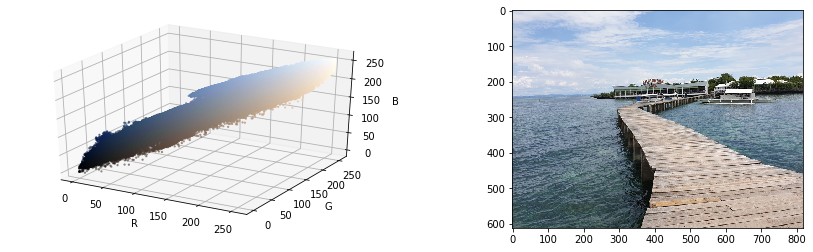

In [31]:
plot3dhistRGB(imgI)

In [13]:
import plotly.graph_objects as go
import mpl_toolkits.mplot3d.axes3d as p3


def plotHist3d(img):
    imgFlat = np.array([img[:,:,c].ravel() for c in range(3)])
    colorRGB=''
    fig = go.Figure(data=[go.Scatter3d(
        x=imgFlat[0],y=imgFlat[1],z=imgFlat[2],
        mode='markers',
        marker=dict(
            size=1,
            #color= 'rgb({}, {}, {})'.format(x/255,y/255,z/255) , #10,20,30)] ,# set color to an array/list of desired values
            #color = rgb(imgFlat[0],imgFlat[1],imgFlat[2]),
            #colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])

    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

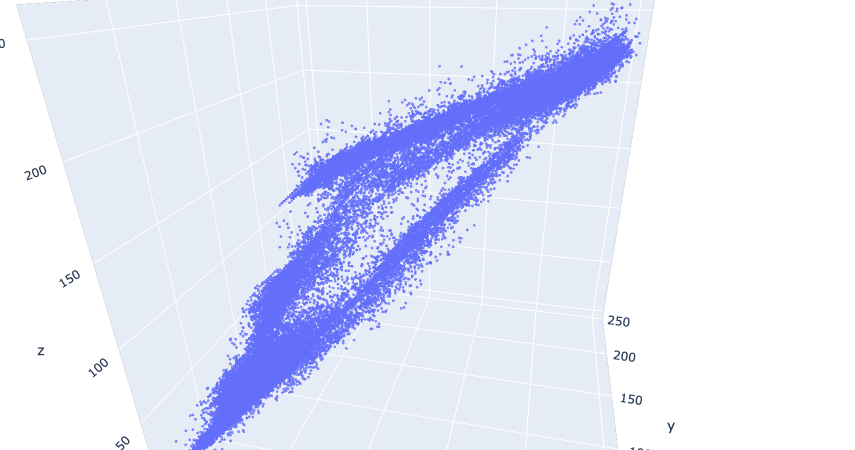

In [14]:
plotHist3d(imgI)

In [10]:
#TODO deprecated
import cv2

def plt_hist(img):
    color = ('b','g','r')
    fig = plt.figure(figsize=(15, 4)) 
    plt.subplot(121), plt.imshow(img)
    plt.subplot(122)
    for i,col in enumerate(color):
         histr = cv2.calcHist([img],[i],None,[256],[0,256])
         plt.plot(histr,color = col)
         plt.xlim([0,256])
    plt.show()

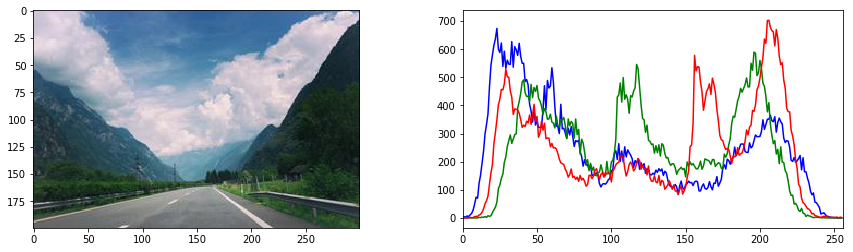

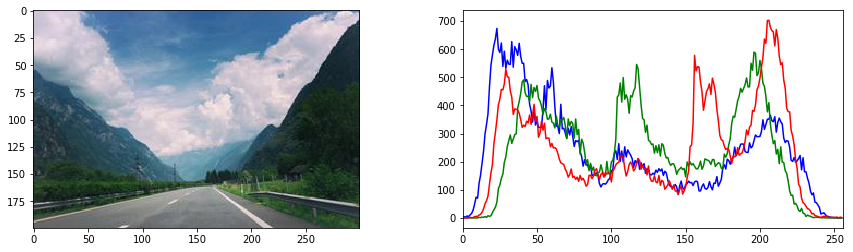

In [11]:
#TODO deprecated

histI=np.asarray([np.histogram(imgI[:,:,i], bins=255)[0] for i in range(3)])
histM=np.asarray([np.histogram(imgI[:,:,i], bins=255)[0] for i in range(3)])

plt_hist(imgI)
plt_hist(imgM)